# Data Augmentation

- Artificiellt skapar mer bilder, när vi har lite data
- Slumpmässigt roterar till en viss grad (radianer)
- Slumpämssigt translatera
- Slumpmässigt flippa horisontellt, vertikalt (spegla)
- shear / skjuvning
- ...

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.datasets.mnist import load_data

In [4]:
(X_train, y_train), (X_test, y_test) = load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
def plot_samples(data, nrows=2, ncols=5, figsize=(12, 4)):
    
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i,:,:], cmap="gray") #0-9 and all rows and columns
        ax.axis("off")

    fig.subplots_adjust(wspace=0, hspace=.1, bottom=0)

In [6]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_test.min(), X_test.max()

(0.0, 1.0)

### Train | val | test split

In [7]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1/6, random_state = 42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape, X_val.shape, y_train_val.shape, y_val.shape

((50000, 28, 28, 1), (10000, 28, 28, 1), (50000,), (10000,))

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
                        rotation_range=10,
                        shear_range=.2,
                        zoom_range=.1,
                        horizontal_flip=False, 
                        height_shift_range=.2, 
                        width_shift_range=.2
                        )

# Don't augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x7f2601dc9750>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x7f2601dc95d0>)

2
(32, 28, 28, 1)


array([9, 9, 2, 5, 5, 7, 3, 0, 3, 9, 4, 5, 9, 6, 2, 9, 1, 4, 3, 9, 4, 4,
       4, 4, 4, 3, 2, 3, 1, 3, 9, 6], dtype=uint8)

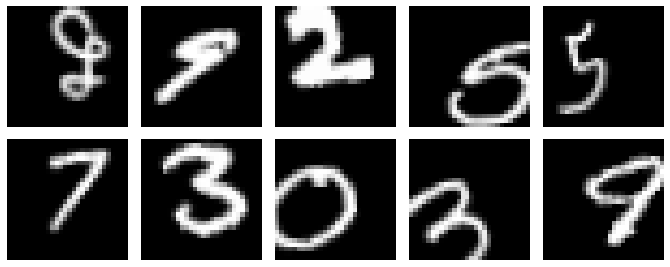

In [9]:
print(len(train_val_generator.next())) #next is an iterator object, .next brings us to the next batch

sample_batch = train_val_generator.next() #32 samples with 28*28 pixels in our first batch
print(sample_batch[0].shape)

plot_samples(sample_batch[0])
sample_batch[1]

### CNN Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=.001, drop_rate=.5, kernels=[32, 32]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name="CNN_model")

    # The convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, 
                            kernel_size=(3, 3), 
                            activation="relu", 
                            kernel_initializer="he_normal", 
                            input_shape=X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    
    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"])

    return model

model = CNN_model(drop_rate=.5)
model.summary()    

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               20

### Train on augmented data

In [11]:
steps_per_epoch = int(len(X_train_val)/32)
validation_steps = int(len(X_val)/32)

steps_per_epoch, validation_steps

#We make sure that it will train on all of the data, since we use mini batch

(1562, 312)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True)

model.fit(train_val_generator, 
         steps_per_epoch = steps_per_epoch, 
         epochs = 100, 
         callbacks = [early_stopper], 
         validation_data=val_generator, 
         validation_steps = validation_steps)

2022-04-28 08:55:40.235684: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-28 08:55:41.431046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1562/1562 [==============================] - 26s 12ms/step - loss: 0.6185 - acc: 0.7969 - val_loss: 0.1262 - val_acc: 0.9638
Epoch 2/100
1562/1562 [==============================] - 21s 13ms/step - loss: 0.2628 - acc: 0.9163 - val_loss: 0.0894 - val_acc: 0.9741
Epoch 3/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.2041 - acc: 0.9360 - val_loss: 0.0725 - val_acc: 0.9784
Epoch 4/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1799 - acc: 0.9433 - val_loss: 0.0655 - val_acc: 0.9787
Epoch 5/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1686 - acc: 0.9483 - val_loss: 0.0595 - val_acc: 0.9832
Epoch 6/100
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1533 - acc: 0.9518 - val_loss: 0.0474 - val_acc: 0.9852
Epoch 7/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1397 - acc: 0.9564 - val_loss: 0.0438 - val_acc: 0.9879
Epoch 8/100
1562/1562 [==============================

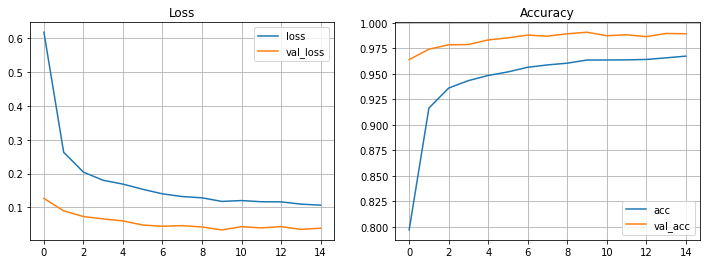

In [13]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics)

### Train on all training data

In [14]:
train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)

In [15]:
model = CNN_model()
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs = 15)

Epoch 1/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.6192 - acc: 0.7984
Epoch 2/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.2692 - acc: 0.9156
Epoch 3/15
1562/1562 [==============================] - 18s 12ms/step - loss: 0.2088 - acc: 0.9331
Epoch 4/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1862 - acc: 0.9414
Epoch 5/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1622 - acc: 0.9487
Epoch 6/15
1562/1562 [==============================] - 18s 12ms/step - loss: 0.1529 - acc: 0.9518
Epoch 7/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1415 - acc: 0.9564
Epoch 8/15
1562/1562 [==============================] - 18s 12ms/step - loss: 0.1321 - acc: 0.9585
Epoch 9/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1302 - acc: 0.9600
Epoch 10/15
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1203 - acc: 0.9627
Epoch 11/

### Confusion Matrix

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.97      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



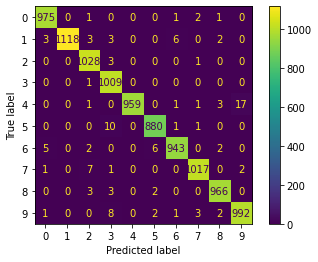

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
